In [35]:
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
from tqdm import tqdm
import matplotlib.pyplot as plt

NST Architecture using VGG

In [14]:

class VGG(nn.Module):
  def __init__(self):
    super(VGG,self).__init__()
    # self.choosen_layers = ['0','2','5','10','14']
    # self.choosen_layers = ['0','5','10','19','28']
    self.choosen_layers = ['0','2','5','10','14','19','21']
    self.Vgg = models.vgg19(pretrained=True).features

  def forward(self,x):
    features = []
    for layer_num,layer in enumerate(self.Vgg):
      x = layer(x)
      if str(layer_num) in self.choosen_layers:
        features.append(x)
    return features

def load_image(img):
  image = Image.open(img).convert("RGB")
  image = loader(image).unsqueeze(0) #unsquezzing here to add another dim for the batch size of images
  return image.to(device)


Initialisation

In [31]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu" )
image_size = 512
loader = transforms.Compose([transforms.Resize((image_size,image_size)),transforms.ToTensor()])
original_img =  load_image("/content/feature_image.jpg")
style_img = load_image("/content/style_image.png")
model = VGG().to(device).eval() #freezing the weights

generated_img = original_img.clone().requires_grad_(True)

# Hyperparameters
total_steps = 5000
learning_rate = 0.001
alpha = 1 # for content loss
beta =  0.01 # for style reservation
optimizer = optim.Adam([generated_img],lr = learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
loss = []
steps = []
# Generating Image
def NST(original_img,style_img,generated_img, model = model ,total_steps = total_steps):
    for step in tqdm(range(total_steps)):

        generated_features = model(generated_img)
        original_features = model(original_img)
        style_features = model(style_img)
        content_loss = 0
        style_loss = 0

        for original_feature,style_feature,generated_feature in zip(original_features,style_features,generated_features):
            batch_size,channel,height,width = generated_feature.shape
            content_loss = torch.mean((generated_feature - original_feature)**2)
            # Gram Matrices computation
            # Multiplying each pixel in a channel with all other channels
            G = generated_feature.view(channel,height*width).mm(generated_feature.view(channel,height*width).t())
            S = style_feature.view(channel,height*width).mm(style_feature.view(channel,height*width).t())

            style_loss +=torch.mean((G  - S)**2)

        total_loss = alpha*content_loss + beta*style_loss
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print("Steps :",step,"Total loss:", total_loss)
            loss.append(total_loss.item())
            steps.append(step)

    return generated_img


In [33]:
Final_img =  NST(original_img,style_img,generated_img, model = model ,total_steps = total_steps)

  0%|          | 0/5000 [00:00<?, ?it/s]

Steps : 0 Total loss: 

  0%|          | 3/5000 [00:00<12:50,  6.48it/s]

tensor(22242358., device='cuda:0', grad_fn=<AddBackward0>)


  2%|▏         | 100/5000 [00:28<23:22,  3.49it/s]

Steps : 100 Total loss: 

  2%|▏         | 103/5000 [00:28<21:04,  3.87it/s]

tensor(7946278., device='cuda:0', grad_fn=<AddBackward0>)


  4%|▍         | 200/5000 [00:56<23:14,  3.44it/s]

Steps : 200 Total loss: 

  4%|▍         | 203/5000 [00:57<20:59,  3.81it/s]

tensor(5230593., device='cuda:0', grad_fn=<AddBackward0>)


  6%|▌         | 300/5000 [01:26<22:57,  3.41it/s]

Steps : 300 Total loss: 

  6%|▌         | 303/5000 [01:27<20:43,  3.78it/s]

tensor(3724397.5000, device='cuda:0', grad_fn=<AddBackward0>)


  8%|▊         | 400/5000 [01:55<23:08,  3.31it/s]

Steps : 400 Total loss: 

  8%|▊         | 403/5000 [01:56<20:51,  3.67it/s]

tensor(2620828.5000, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█         | 500/5000 [02:25<22:25,  3.34it/s]

Steps : 500 Total loss: 

 10%|█         | 503/5000 [02:26<20:10,  3.71it/s]

tensor(1745677.1250, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▏        | 600/5000 [02:55<21:54,  3.35it/s]

Steps : 600 Total loss: 

 12%|█▏        | 603/5000 [02:56<19:42,  3.72it/s]

tensor(1091273.5000, device='cuda:0', grad_fn=<AddBackward0>)


 14%|█▍        | 700/5000 [03:25<21:32,  3.33it/s]

Steps : 700 Total loss: 

 14%|█▍        | 703/5000 [03:26<19:22,  3.69it/s]

tensor(669900.5625, device='cuda:0', grad_fn=<AddBackward0>)


 16%|█▌        | 800/5000 [03:55<20:57,  3.34it/s]

Steps : 800 Total loss: 

 16%|█▌        | 803/5000 [03:56<18:49,  3.71it/s]

tensor(425981.3438, device='cuda:0', grad_fn=<AddBackward0>)


 18%|█▊        | 900/5000 [04:25<20:27,  3.34it/s]

Steps : 900 Total loss: 

 18%|█▊        | 903/5000 [04:26<18:23,  3.71it/s]

tensor(287743.1562, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██        | 1000/5000 [04:55<19:55,  3.35it/s]

Steps : 1000 Total loss: 

 20%|██        | 1003/5000 [04:56<17:55,  3.72it/s]

tensor(205141.3750, device='cuda:0', grad_fn=<AddBackward0>)


 22%|██▏       | 1100/5000 [05:25<19:26,  3.34it/s]

Steps : 1100 Total loss: 

 22%|██▏       | 1103/5000 [05:26<17:42,  3.67it/s]

tensor(152475.9688, device='cuda:0', grad_fn=<AddBackward0>)


 24%|██▍       | 1200/5000 [05:55<18:58,  3.34it/s]

Steps : 1200 Total loss: 

 24%|██▍       | 1203/5000 [05:56<17:03,  3.71it/s]

tensor(117262.6719, device='cuda:0', grad_fn=<AddBackward0>)


 26%|██▌       | 1300/5000 [06:25<18:26,  3.34it/s]

Steps : 1300 Total loss: 

 26%|██▌       | 1303/5000 [06:26<16:36,  3.71it/s]

tensor(92913.0938, device='cuda:0', grad_fn=<AddBackward0>)


 28%|██▊       | 1400/5000 [06:55<17:55,  3.35it/s]

Steps : 1400 Total loss: 

 28%|██▊       | 1403/5000 [06:56<16:08,  3.71it/s]

tensor(75601.9453, device='cuda:0', grad_fn=<AddBackward0>)


 30%|███       | 1500/5000 [07:25<17:26,  3.34it/s]

Steps : 1500 Total loss: 

 30%|███       | 1503/5000 [07:26<15:41,  3.71it/s]

tensor(62922.8594, device='cuda:0', grad_fn=<AddBackward0>)


 32%|███▏      | 1600/5000 [07:55<16:58,  3.34it/s]

Steps : 1600 Total loss: 

 32%|███▏      | 1603/5000 [07:55<15:14,  3.71it/s]

tensor(53376.9727, device='cuda:0', grad_fn=<AddBackward0>)


 34%|███▍      | 1700/5000 [08:25<16:28,  3.34it/s]

Steps : 1700 Total loss: 

 34%|███▍      | 1703/5000 [08:25<14:48,  3.71it/s]

tensor(46003.9688, device='cuda:0', grad_fn=<AddBackward0>)


 36%|███▌      | 1800/5000 [08:54<15:58,  3.34it/s]

Steps : 1800 Total loss: 

 36%|███▌      | 1803/5000 [08:55<14:29,  3.68it/s]

tensor(40187.3359, device='cuda:0', grad_fn=<AddBackward0>)


 38%|███▊      | 1900/5000 [09:24<15:28,  3.34it/s]

Steps : 1900 Total loss: 

 38%|███▊      | 1903/5000 [09:25<13:57,  3.70it/s]

tensor(35502.2812, device='cuda:0', grad_fn=<AddBackward0>)


 40%|████      | 2000/5000 [09:54<14:59,  3.34it/s]

Steps : 2000 Total loss: 

 40%|████      | 2003/5000 [09:55<13:31,  3.69it/s]

tensor(31667.5312, device='cuda:0', grad_fn=<AddBackward0>)


 42%|████▏     | 2100/5000 [10:24<14:30,  3.33it/s]

Steps : 2100 Total loss: 

 42%|████▏     | 2103/5000 [10:25<13:02,  3.70it/s]

tensor(28487.7305, device='cuda:0', grad_fn=<AddBackward0>)


 44%|████▍     | 2200/5000 [10:54<13:58,  3.34it/s]

Steps : 2200 Total loss: 

 44%|████▍     | 2203/5000 [10:55<12:36,  3.70it/s]

tensor(25821.3867, device='cuda:0', grad_fn=<AddBackward0>)


 46%|████▌     | 2300/5000 [11:25<13:32,  3.32it/s]

Steps : 2300 Total loss: 

 46%|████▌     | 2303/5000 [11:25<12:10,  3.69it/s]

tensor(23558.9570, device='cuda:0', grad_fn=<AddBackward0>)


 48%|████▊     | 2400/5000 [11:55<13:02,  3.32it/s]

Steps : 2400 Total loss: 

 48%|████▊     | 2403/5000 [11:55<11:43,  3.69it/s]

tensor(21622.3770, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 2500/5000 [12:25<12:30,  3.33it/s]

Steps : 2500 Total loss: 

 50%|█████     | 2503/5000 [12:26<11:15,  3.69it/s]

tensor(19948.0488, device='cuda:0', grad_fn=<AddBackward0>)


 52%|█████▏    | 2600/5000 [12:55<11:57,  3.35it/s]

Steps : 2600 Total loss: 

 52%|█████▏    | 2603/5000 [12:56<10:47,  3.70it/s]

tensor(18491.2129, device='cuda:0', grad_fn=<AddBackward0>)


 54%|█████▍    | 2700/5000 [13:25<11:27,  3.34it/s]

Steps : 2700 Total loss: 

 54%|█████▍    | 2703/5000 [13:25<10:17,  3.72it/s]

tensor(17214.6055, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████▌    | 2800/5000 [13:54<10:57,  3.34it/s]

Steps : 2800 Total loss: 

 56%|█████▌    | 2803/5000 [13:55<09:51,  3.71it/s]

tensor(16092.5137, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████▊    | 2900/5000 [14:24<10:27,  3.34it/s]

Steps : 2900 Total loss: 

 58%|█████▊    | 2903/5000 [14:25<09:24,  3.71it/s]

tensor(15098.9082, device='cuda:0', grad_fn=<AddBackward0>)


 60%|██████    | 3000/5000 [14:54<09:58,  3.34it/s]

Steps : 3000 Total loss: 

 60%|██████    | 3003/5000 [14:55<08:57,  3.72it/s]

tensor(14213.7607, device='cuda:0', grad_fn=<AddBackward0>)


 62%|██████▏   | 3100/5000 [15:24<09:29,  3.34it/s]

Steps : 3100 Total loss: 

 62%|██████▏   | 3103/5000 [15:25<08:31,  3.71it/s]

tensor(13419.7002, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████▍   | 3200/5000 [15:54<08:59,  3.33it/s]

Steps : 3200 Total loss: 

 64%|██████▍   | 3203/5000 [15:55<08:04,  3.71it/s]

tensor(12703.3818, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████▌   | 3300/5000 [16:24<08:29,  3.34it/s]

Steps : 3300 Total loss: 

 66%|██████▌   | 3303/5000 [16:25<07:39,  3.70it/s]

tensor(12055.0977, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████▊   | 3400/5000 [16:54<08:00,  3.33it/s]

Steps : 3400 Total loss: 

 68%|██████▊   | 3403/5000 [16:55<07:12,  3.69it/s]

tensor(11465.9502, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████   | 3500/5000 [17:24<07:29,  3.33it/s]

Steps : 3500 Total loss: 

 70%|███████   | 3503/5000 [17:25<06:45,  3.69it/s]

tensor(10926.7197, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████▏  | 3600/5000 [17:54<06:59,  3.33it/s]

Steps : 3600 Total loss: 

 72%|███████▏  | 3603/5000 [17:55<06:17,  3.70it/s]

tensor(10434.3760, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████▍  | 3700/5000 [18:24<06:30,  3.33it/s]

Steps : 3700 Total loss: 

 74%|███████▍  | 3703/5000 [18:25<05:50,  3.70it/s]

tensor(9983.5479, device='cuda:0', grad_fn=<AddBackward0>)


 76%|███████▌  | 3800/5000 [18:54<05:59,  3.34it/s]

Steps : 3800 Total loss: 

 76%|███████▌  | 3803/5000 [18:55<05:23,  3.70it/s]

tensor(9568.1826, device='cuda:0', grad_fn=<AddBackward0>)


 78%|███████▊  | 3900/5000 [19:24<05:28,  3.35it/s]

Steps : 3900 Total loss: 

 78%|███████▊  | 3903/5000 [19:25<04:55,  3.71it/s]

tensor(9183.9385, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████  | 4000/5000 [19:54<04:58,  3.35it/s]

Steps : 4000 Total loss: 

 80%|████████  | 4003/5000 [19:55<04:28,  3.72it/s]

tensor(8829.0029, device='cuda:0', grad_fn=<AddBackward0>)


 82%|████████▏ | 4100/5000 [20:24<04:29,  3.34it/s]

Steps : 4100 Total loss: 

 82%|████████▏ | 4103/5000 [20:25<04:02,  3.70it/s]

tensor(8497.3271, device='cuda:0', grad_fn=<AddBackward0>)


 84%|████████▍ | 4200/5000 [20:54<03:59,  3.34it/s]

Steps : 4200 Total loss: 

 84%|████████▍ | 4203/5000 [20:55<03:34,  3.71it/s]

tensor(8187.2441, device='cuda:0', grad_fn=<AddBackward0>)


 86%|████████▌ | 4300/5000 [21:24<03:29,  3.34it/s]

Steps : 4300 Total loss: 

 86%|████████▌ | 4303/5000 [21:25<03:07,  3.71it/s]

tensor(7897.0020, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████▊ | 4400/5000 [21:54<02:59,  3.34it/s]

Steps : 4400 Total loss: 

 88%|████████▊ | 4403/5000 [21:55<02:41,  3.69it/s]

tensor(7624.8159, device='cuda:0', grad_fn=<AddBackward0>)


 90%|█████████ | 4500/5000 [22:24<02:30,  3.32it/s]

Steps : 4500 Total loss: 

 90%|█████████ | 4503/5000 [22:25<02:14,  3.68it/s]

tensor(7369.1353, device='cuda:0', grad_fn=<AddBackward0>)


 92%|█████████▏| 4600/5000 [22:54<01:59,  3.34it/s]

Steps : 4600 Total loss: 

 92%|█████████▏| 4603/5000 [22:55<01:47,  3.71it/s]

tensor(7127.9409, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████▍| 4700/5000 [23:24<01:29,  3.35it/s]

Steps : 4700 Total loss: 

 94%|█████████▍| 4703/5000 [23:25<01:19,  3.72it/s]

tensor(6899.5962, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████▌| 4800/5000 [23:54<01:00,  3.33it/s]

Steps : 4800 Total loss: 

 96%|█████████▌| 4803/5000 [23:55<00:53,  3.71it/s]

tensor(6681.5332, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████▊| 4900/5000 [24:24<00:30,  3.33it/s]

Steps : 4900 Total loss: 

 98%|█████████▊| 4903/5000 [24:25<00:26,  3.69it/s]

tensor(6474.7515, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 5000/5000 [24:54<00:00,  3.35it/s]


In [38]:
save_image(Final_img , "Generated_final_1.png")

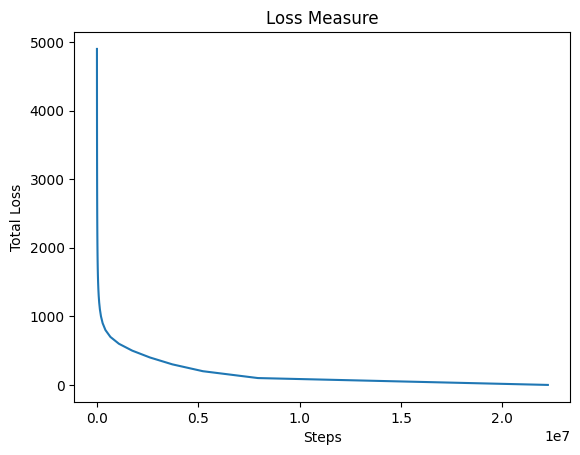

In [36]:
# Plotting loss
plt.plot(loss,steps)
plt.title('Loss Measure')
plt.xlabel('Steps')
plt.ylabel('Total Loss')

# Show the plot
plt.show()


In [ ]:
plt.savefig("Loss Measure.jpg")

Style Image

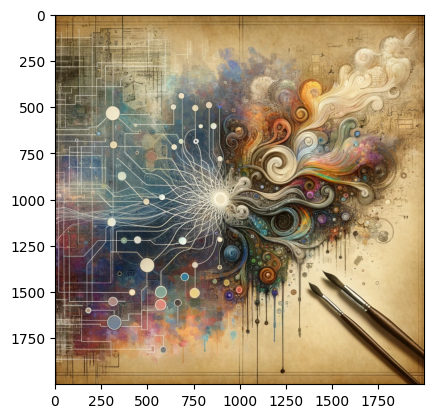

In [49]:
plt.imshow(plt.imread("style_image.png"))

Feature Image 1

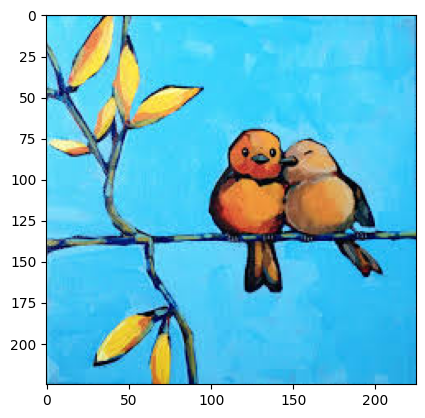

In [50]:
plt.imshow(plt.imread("feature_image1.jpg"))

Generated Image 1

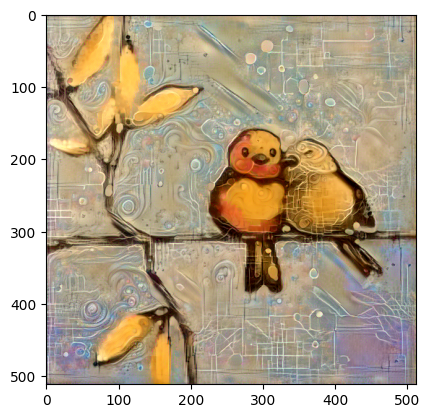

In [41]:
plt.imshow(plt.imread("Generated_final_1.png"))

Feature Image 2

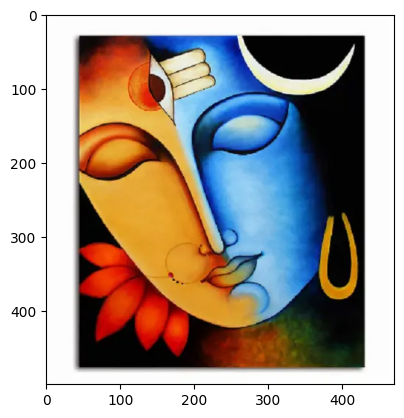

In [43]:
plt.imshow(plt.imread("feature_image2.jpg"))

Generated Image 2

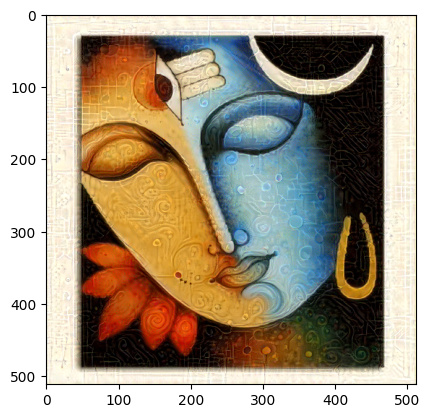

In [47]:
plt.imshow(plt.imread("Generated_final_2.png"));